# 01_Library

## install

In [1]:
! pip install -q torchmetrics

## import

In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [3]:
!python --version

Python 3.11.11


In [4]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
pandas --> 2.2.2
cv2 --> 4.11.0
PIL --> 11.1.0
sklearn --> 1.6.1
torch --> 2.5.1+cu124
torchvision --> 0.20.1+cu124
tqdm --> 4.67.1
torchmetrics --> 1.6.2


------------------

# 02_Utils

## device

In [5]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## system

In [6]:
system= "colab"

if system== "local":
    drive_path= r"./"
    dataset_folder= './UTKFace/'
elif system== "colab":
    drive_path= r"/content/drive/MyDrive/Catalist/0_age estimation/"
    dataset_folder= '/content/UTKFace/'

## avragemeter

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## number of parameter fn

In [8]:
def num_trainable_params(model):
  nums= sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

## drive mount

In [9]:
if system== "colab":
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


----------------

# 03_Data



In [10]:
if system== "colab":
    data_path= os.path.join(drive_path,'UTKFace.tar.gz')
    ! tar -xzf "{data_path}" -C '/content/'

--------

# 04_EDA (Exploratory Data Analysis)

## show sample of images

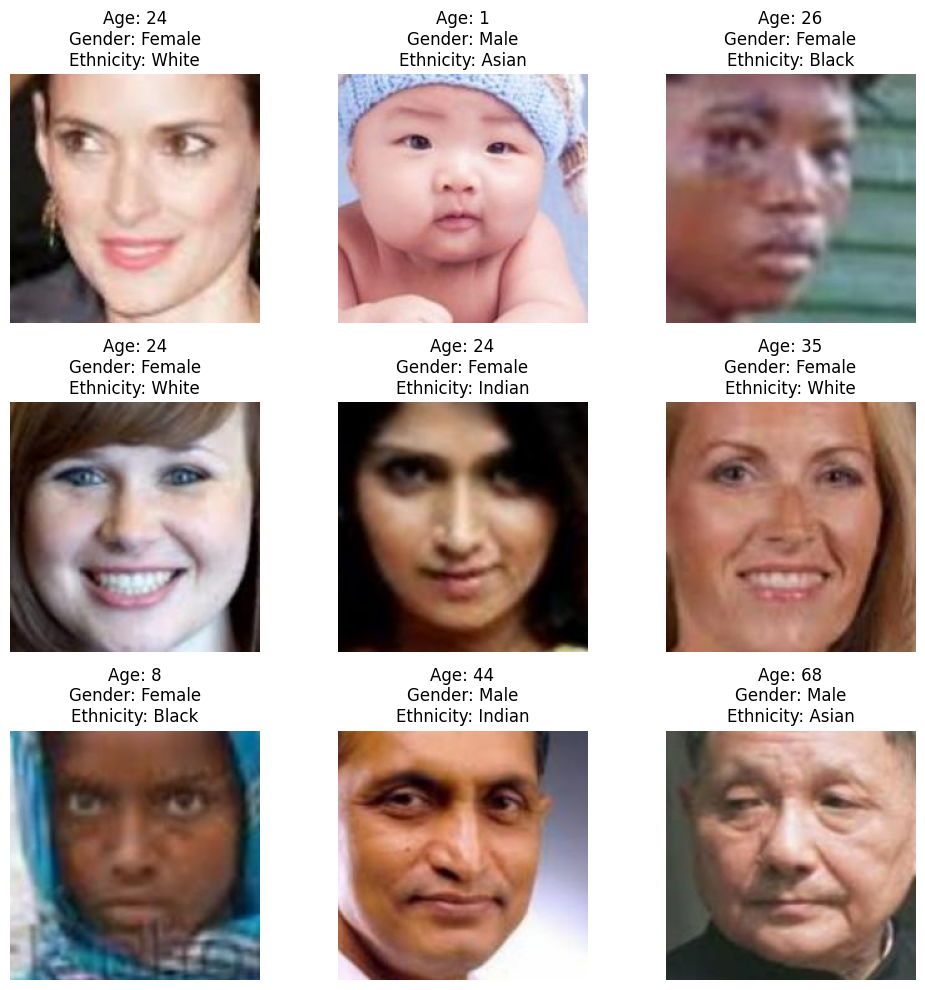

In [11]:
def show_random_samples(num_samples= 9):
    image_files= os.listdir(dataset_folder)
    selected_image_files= random.sample(image_files, num_samples)

    plt.figure(figsize= (10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path= os.path.join(dataset_folder, image_file)
        age, gender, ethnicity= image_file.split('_')[:3]

        image = Image.open(image_path)

        gender= 'Male' if int(gender)== 0 else 'Female'
        ethnicity= ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_samples()

## create csv file contain list of images

In [12]:
image_names, ages, ethnicities, genders= [], [], [], []

for filename in os.listdir(dataset_folder):
    if filename.endswith('.jpg'):

        parts= filename.split('_')
        if len(parts) < 4:
          print(filename)
          continue

        age= int(parts[0])
        gender= 'Male' if int(parts[1]) == 0 else 'Female'
        ethnicity= ['White', 'Black', 'Asian', 'Indian', 'Others'][int(parts[2])]

        if age > 80:
          continue

        image_names.append(filename)
        ages.append(age)
        ethnicities.append(ethnicity)
        genders.append(gender)

data= {
    'image_name': image_names,
    'age': ages,
    'ethnicity': ethnicities,
    'gender': genders
}
df= pd.DataFrame(data)

csv_filename = os.path.join(drive_path, 'utkface_dataset.csv')
df.to_csv(csv_filename, index=False)

print(f"CSV file '{csv_filename}' created successfully.")

61_1_20170109150557335.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
39_1_20170116174525125.jpg.chip.jpg
CSV file '/content/drive/MyDrive/Catalist/0_age estimation/utkface_dataset.csv' created successfully.


In [13]:
df

,image_name,age,ethnicity,gender
0,8_1_3_20170104221828238.jpg.chip.jpg,8,Indian,Female
1,46_0_1_20170117185815162.jpg.chip.jpg,46,Black,Male
2,45_1_3_20170119200125452.jpg.chip.jpg,45,Indian,Female
3,15_0_0_20170104012102240.jpg.chip.jpg,15,White,Male
4,27_1_2_20170116173459838.jpg.chip.jpg,27,Asian,Female
...,...,...,...,...
23160,30_0_0_20170109015231305.jpg.chip.jpg,30,White,Male
23161,30_1_4_20170117203009657.jpg.chip.jpg,30,Others,Female
23162,24_1_0_20170104022030117.jpg.chip.jpg,24,White,Female
23163,52_0_2_20170116192904934.jpg.chip.jpg,52,Asian,Male


## histogram

### age

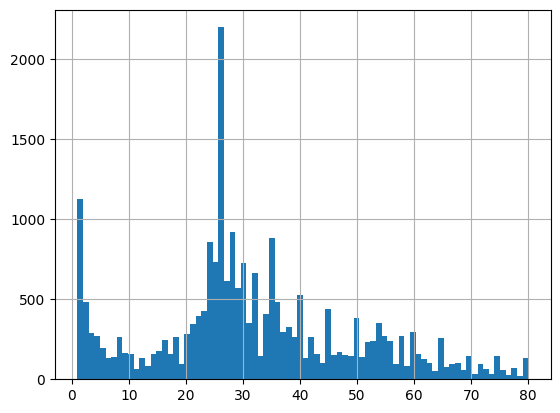

In [14]:
df['age'].hist(bins= len(df.age.unique()));

### gender

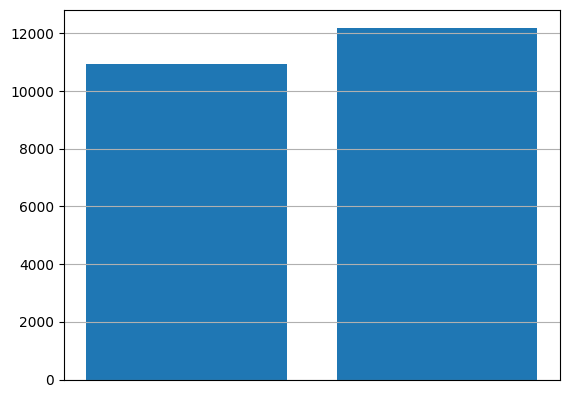

In [15]:
df['gender'].hist(bins= len(df.gender.unique()), rwidth= 0.8);

In [16]:
df.gender.value_counts()

,count
gender,
Male,12208
Female,10957


### race

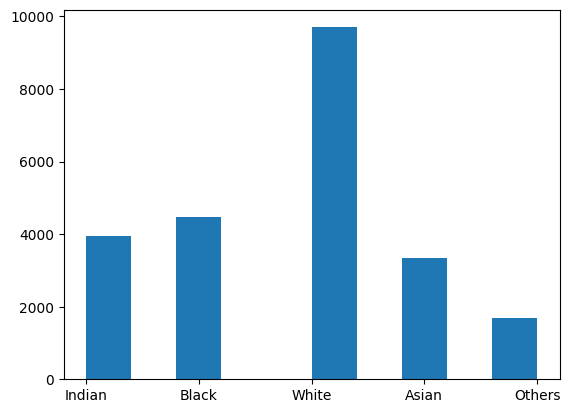

In [17]:
plt.hist(df.ethnicity);

## crosstab

### age-race

In [18]:
pd.crosstab(df.gender, df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1810,2182,1698,930,4337
Male,1538,2296,2254,759,5361


## boxplot & violinplot

### gender

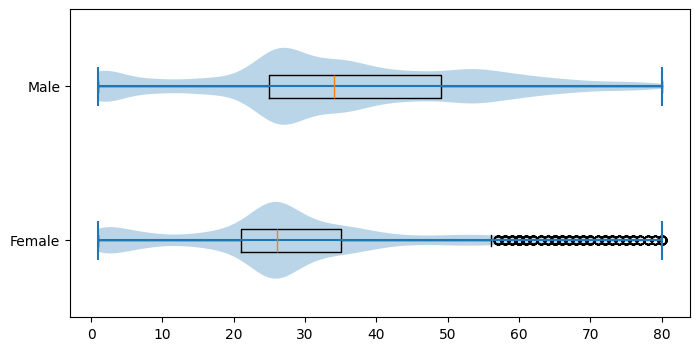

In [19]:
plt.figure(figsize= (8,4))
plt.boxplot([df.age[df.gender== sex] for sex in df.gender.unique()],
            tick_labels= df.gender.unique(),
            vert= False)
plt.violinplot([df.age[df.gender== sex] for sex in df.gender.unique()],
               vert= False);

### race

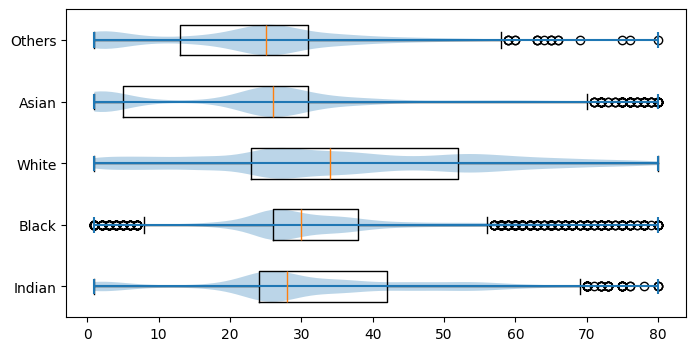

In [20]:
plt.figure(figsize= (8,4))
plt.boxplot([df.age[df.ethnicity== race] for race in df.ethnicity.unique()],
            tick_labels= df.ethnicity.unique(),
            vert= False)
plt.violinplot([df.age[df.ethnicity== race] for race in df.ethnicity.unique()],
               vert= False);

----------

# 05_Split data

In [21]:
df_train_raw, df_test= train_test_split(df, test_size= 0.2,
                                        stratify= df.age, random_state= 42)
df_train, df_valid= train_test_split(df_train_raw, test_size= 0.2,
                                          stratify= df_train_raw.age, random_state= 42)

print(f'train: {df_train.shape}, valid: {df_valid.shape}, test: {df_test.shape}')

train: (14825, 4), valid: (3707, 4), test: (4633, 4)


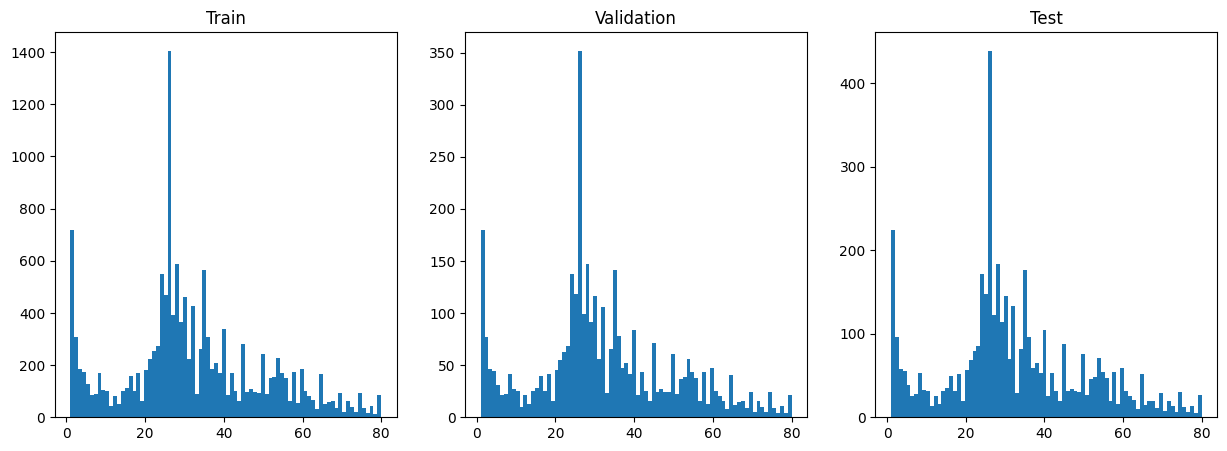

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

In [23]:
df_train.to_csv(os.path.join(drive_path,'train_set.csv'), index= False)
df_valid.to_csv(os.path.join(drive_path, 'valid_set.csv'), index= False)
df_test.to_csv(os.path.join(drive_path, 'test_set.csv'), index= False)

print('All CSV files created successfully.')

All CSV files created successfully.


--------

# 06_Transform

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees= 15),
    transforms.ColorJitter(brightness= 0.2, contrast= 0.2, saturation= 0.2, hue= 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225]),
])

----------

# 07_Custom dataset

In [25]:
class UTK_Dataset(Dataset):
  def __init__(self, root_dir, csv_file, transform):
    self.root_dir, self.csv_file, self.transform= root_dir, csv_file, transform
    self.data= pd.read_csv(self.csv_file)
    self.gender_map= {'Male': 0, 'Female': 1}
    self.race_map= {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample= self.data.iloc[idx, :]
    img_name= sample.image_name
    image= Image.open(os.path.join(self.root_dir, img_name))
    image= self.transform(image)

    age= torch.tensor([sample.age], dtype= torch.float32)
    gender= torch.tensor(self.gender_map[sample.gender], dtype= torch.int32)
    race= torch.tensor(self.race_map[sample.ethnicity], dtype= torch.int32)
    return image, age, gender, race

In [26]:
train_dataset= UTK_Dataset(dataset_folder, os.path.join(drive_path, 'train_set.csv'), train_transform)
valid_dataset= UTK_Dataset(dataset_folder, os.path.join(drive_path, 'valid_set.csv'), test_transform)
test_dataset= UTK_Dataset(dataset_folder, os.path.join(drive_path, 'test_set.csv'), test_transform)

In [27]:
smp= random.randint(0,len(train_dataset))
img, ag, gndr, rc= train_dataset[smp]
print(img.shape, ag, gndr, rc)

torch.Size([3, 128, 128]) tensor([68.]) tensor(1, dtype=torch.int32) tensor(0, dtype=torch.int32)


----------

# 08_DataLoader

In [28]:
train_loader= DataLoader(train_dataset, batch_size= 128, shuffle= True)
valid_loader= DataLoader(valid_dataset, batch_size= 256, shuffle= False)
test_loader= DataLoader(test_dataset, batch_size= 256, shuffle= False)

print("train batch size:",train_loader.batch_size,
     ", num of batch:", len(train_loader))
print("valid batch size:",valid_loader.batch_size,
     ", num of batch:", len(valid_loader))
print("Test batch size:",test_loader.batch_size,
     ", num of batch:", len(test_loader))

train batch size: 128 , num of batch: 116
valid batch size: 256 , num of batch: 15
Test batch size: 256 , num of batch: 19


In [29]:
imgs, ags, gndrs, rcs= next(iter(train_loader));
print(imgs.shape, ags.shape, gndrs.shape, rcs.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128, 1]) torch.Size([128]) torch.Size([128])


--------

# 09_Model

In [30]:
class Age_estimator(nn.Module):
  def __init__(self):
    super().__init__()
    self.Model= models.resnet50(weights= models.ResNet50_Weights.IMAGENET1K_V2)
    self.Model.fc= nn.LazyLinear(1)

  def forward(self, x):
    y= self.Model(x)
    return y

In [31]:
age_model= Age_estimator()
age_model(imgs).shape

torch.Size([128, 1])

-------

# 10_Configuration

In [32]:
lr= 0.02
momentum= 0.9
weight_decay= 1e-4
age_model.to(device)
optimizer= optim.SGD(age_model.parameters(), lr,
                     momentum= momentum,
                     weight_decay= weight_decay)
loss_fn= nn.L1Loss()
metric= tm.MeanAbsoluteError().to(device)

-----------

# 11_One Epoch fn

## train

In [33]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch= None):
  model.train()
  loss_train= AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit= 'batch') as tepoch:
    for inputs, targets, _, _ in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs= inputs.to(device)
      targets= targets.to(device)
      outputs= model(inputs)
      loss= loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)
      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

## evalution

In [34]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval= AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets, _, _ in test_loader:
      inputs= inputs.to(device)
      targets= targets.to(device)
      outputs= model(inputs)

      loss= loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n= len(targets))
      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

-------

# 12_Experiments before the main training

## base metrics

In [35]:
base_loss= []
base_metric= []
for i in range(10):
  age_model= Age_estimator().to(device)
  inputs, targets, _, _= next(iter(train_loader))
  inputs, targets= inputs.to(device), targets.to(device)

  with torch.no_grad():
    outputs= age_model(inputs)
    base_loss.append(loss_fn(outputs, targets))
    base_metric.append(metric(outputs, targets))

print(f'base loss: {sum(base_loss)/len(base_loss):.4},')
print(f'base metric: {sum(base_metric)/ len(base_metric):.4}')

base loss: 32.24,
base metric: 32.24


## overfit on subset of data

In [36]:
num_epochs= 10
mini_train_size= 1000
mini_batch_size= 50

_, mini_train_dataset= random_split(train_dataset,
                                   (len(train_dataset)- mini_train_size,
                                    mini_train_size))
mini_train_loader= DataLoader(mini_train_dataset, mini_batch_size)
age_model= Age_estimator().to(device)
optimizer= torch.optim.SGD(age_model.parameters(), lr=1e-2, momentum=0.9)

for epoch in range(num_epochs):
  age_model, _, _ = train_one_epoch(age_model, mini_train_loader, loss_fn,
                                    optimizer, metric, epoch)

Epoch 9: 100%|██████████| 20/20 [00:09<00:00,  2.11batch/s, loss=8.58, metric=8.58]


## grid search

In [37]:
num_epochs= 3

for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  age_model= Age_estimator().to(device)
  optimizer= optim.SGD(age_model.parameters(), lr= lr,
                       weight_decay= 1e-4, momentum= 0.9)

  for epoch in range(num_epochs):
    age_model, _, _= train_one_epoch(age_model, train_loader, loss_fn,
                                 optimizer, metric, epoch)
  print()

LR=0.1


Epoch 2: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=9.86, metric=9.86]



LR=0.01


Epoch 2: 100%|██████████| 116/116 [01:49<00:00,  1.06batch/s, loss=6.21, metric=6.21]



LR=0.001


Epoch 2: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=6.13, metric=6.13]



LR=0.0001


Epoch 2: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=13.7, metric=13.7]

In [38]:
num_epochs= 3

for lr in [0.003, 0.001, 0.0008]:
  for wd in [1e-4, 0.]:
    print(f'LR={lr}, WD={wd}')
    age_model= Age_estimator().to(device)
    optimizer= optim.SGD(age_model.parameters(), lr= lr, weight_decay= wd, momentum= 0.9)

    for epoch in range(num_epochs):
      age_model, loss, _= train_one_epoch(age_model, train_loader,
                                          loss_fn, optimizer, metric, epoch)
    print()

LR=0.003, WD=0.0001


Epoch 2: 100%|██████████| 116/116 [01:49<00:00,  1.06batch/s, loss=5.9, metric=5.9]



LR=0.003, WD=0.0


Epoch 2: 100%|██████████| 116/116 [01:49<00:00,  1.06batch/s, loss=5.75, metric=5.75]



LR=0.001, WD=0.0001


Epoch 2: 100%|██████████| 116/116 [01:49<00:00,  1.05batch/s, loss=6.27, metric=6.27]



LR=0.001, WD=0.0


Epoch 2: 100%|██████████| 116/116 [01:49<00:00,  1.06batch/s, loss=6.05, metric=6.05]



LR=0.0008, WD=0.0001


Epoch 2: 100%|██████████| 116/116 [01:49<00:00,  1.06batch/s, loss=6.18, metric=6.18]



LR=0.0008, WD=0.0


Epoch 2: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=6.29, metric=6.29]

----------

# 13_Training

In [39]:
loss_train_hist= []
loss_valid_hist= []

metric_train_hist= []
metric_valid_hist= []

best_loss_valid= torch.inf
epoch_counter= 0

age_model= Age_estimator().to(device)

In [40]:
lr= 0.001
wd= 1e-4
optimizer= optim.SGD(age_model.parameters(), lr= lr,
                     weight_decay= wd, momentum= 0.9)

In [41]:
num_epochs= 15

for epoch in range(num_epochs):
  age_model, loss_train, metric_train= train_one_epoch(age_model, train_loader,
                                                       loss_fn, optimizer,
                                                       metric, epoch)
  loss_valid, metric_valid= evaluate(age_model, valid_loader,
                                     loss_fn, metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(age_model, os.path.join(drive_path, 'age_model.pt'))
    best_loss_valid= loss_valid
    print('Model Saved!')

  print(f'Valid: Loss= {loss_valid:.4}, Metric= {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 116/116 [01:49<00:00,  1.06batch/s, loss=16.4, metric=16.4]


Model Saved!
Valid: Loss= 7.886, Metric= 7.886



Epoch 1: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=7.07, metric=7.07]


Model Saved!
Valid: Loss= 6.015, Metric= 6.015



Epoch 2: 100%|██████████| 116/116 [01:49<00:00,  1.06batch/s, loss=6.03, metric=6.03]


Model Saved!
Valid: Loss= 5.627, Metric= 5.627



Epoch 3: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=5.68, metric=5.68]


Model Saved!
Valid: Loss= 5.587, Metric= 5.587



Epoch 4: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=5.39, metric=5.39]


Model Saved!
Valid: Loss= 5.422, Metric= 5.422



Epoch 5: 100%|██████████| 116/116 [01:49<00:00,  1.06batch/s, loss=5.13, metric=5.13]


Model Saved!
Valid: Loss= 5.198, Metric= 5.198



Epoch 6: 100%|██████████| 116/116 [01:51<00:00,  1.04batch/s, loss=4.9, metric=4.9]


Model Saved!
Valid: Loss= 5.178, Metric= 5.178



Epoch 7: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=4.7, metric=4.7]


Model Saved!
Valid: Loss= 5.053, Metric= 5.053



Epoch 8: 100%|██████████| 116/116 [01:51<00:00,  1.04batch/s, loss=4.49, metric=4.49]


Model Saved!
Valid: Loss= 4.969, Metric= 4.969



Epoch 9: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=4.37, metric=4.37]


Valid: Loss= 4.981, Metric= 4.981



Epoch 10: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=4.26, metric=4.26]


Model Saved!
Valid: Loss= 4.958, Metric= 4.958



Epoch 11: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=4.19, metric=4.19]


Model Saved!
Valid: Loss= 4.841, Metric= 4.841



Epoch 12: 100%|██████████| 116/116 [01:52<00:00,  1.03batch/s, loss=4.09, metric=4.09]


Valid: Loss= 4.972, Metric= 4.972



Epoch 13: 100%|██████████| 116/116 [01:50<00:00,  1.05batch/s, loss=3.97, metric=3.97]


Valid: Loss= 4.889, Metric= 4.889



Epoch 14: 100%|██████████| 116/116 [01:49<00:00,  1.06batch/s, loss=3.81, metric=3.81]


Valid: Loss= 4.997, Metric= 4.997



-----

# 14_Learning curve

## loss

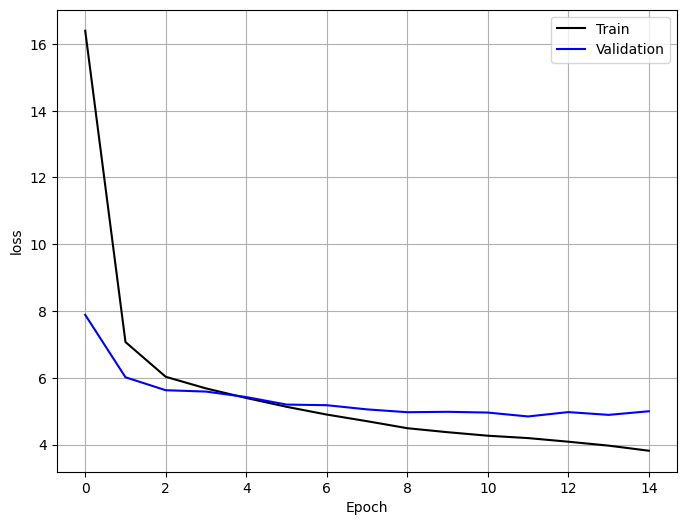

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_train_hist)), loss_train_hist, 'k-', label='Train')
plt.plot(range(len(loss_valid_hist)), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

## metric

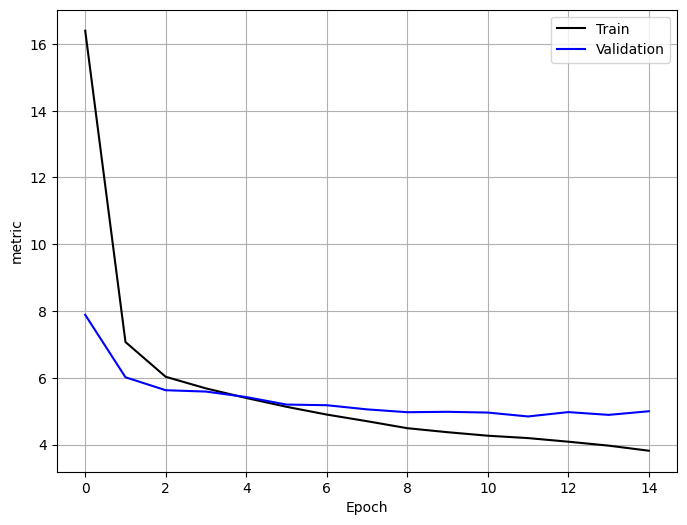

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(metric_train_hist)), metric_train_hist, 'k-', label='Train')
plt.plot(range(len(metric_valid_hist)), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('metric')
plt.grid(True)
plt.legend()

----------

# 15_Test

In [44]:
model_path= os.path.join(drive_path, 'age_model.pt')
age_model= torch.load(model_path)
age_model.eval()

_, metric_train= evaluate(age_model, train_loader, loss_fn, metric)
_, metric_valid= evaluate(age_model, valid_loader, loss_fn, metric)
_, metric_test= evaluate(age_model, test_loader, loss_fn, metric)

print(f'train: {metric_train}')
print(f'valid: {metric_valid}')
print(f'Test: {metric_test}')

<ipython-input-44-ef9f69da8ada>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  age_model= torch.load(model_path)


train: 3.8658530712127686
valid: 4.841324806213379
Test: 4.956283092498779


Real: 50, Predicted: 37


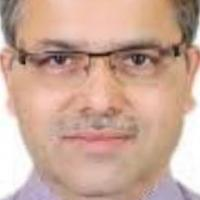

In [45]:
df= pd.read_csv(os.path.join(drive_path, 'test_set.csv'))
test_image_name= df.iloc[random.randint(0, df.shape[0])].image_name
test_image_path= os.path.join(dataset_folder, test_image_name)
img= Image.open(test_image_path).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)
with torch.inference_mode():
  preds= age_model(img_tensor.to(device)).item()
real_age= test_image_name.split('_')[0]
print(f"Real: {real_age}, Predicted: {round(preds)}")
img

-------

# 16_Inference

In [46]:
!pip install face-recognition
import face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=f782fe046fed599bbd5495bc2e2532177a05aae10b4b20f4b56a22d514b65fdb
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models


In [47]:
def inference(image_path, transform, model, face_detection= False):
  if face_detection:
    img= face_recognition.load_image_file(image_path)
    top, right, bottom, left= face_recognition.face_locations(img)[0]
    img_crop= Image.fromarray(img[top:bottom, left:right])
  else:
    img_crop= Image.open(image_path).convert('RGB')

  img_tensor= transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    preds= model(img_tensor.to(device)).item()

  return preds, img_crop

36.65


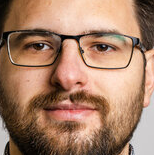

In [48]:
preds, img= inference(os.path.join(drive_path, 'test_image.jpeg'),
          test_transform, age_model, face_detection= True)

print(f'{preds:.2f}')
img

--------

# 17_Experiments

In [49]:
age_model= torch.load(os.path.join(drive_path, 'age_model.pt'), map_location= device)
age_model.eval();

<ipython-input-49-9dd777084c12>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  age_model= torch.load(os.path.join(drive_path, 'age_model.pt'), map_location= device)


## mae for each ages

In [50]:
all_outputs, all_targets= [], []

for inputs, targets, _, _ in test_loader:
  inputs= inputs.to(device)
  targets= targets.to(device)

  with torch.inference_mode():
    outputs= age_model(inputs)

  all_outputs.append(outputs)
  all_targets.append(targets)

all_outputs= torch.vstack(all_outputs).squeeze()
all_targets= torch.vstack(all_targets).squeeze()
mae= F.l1_loss(all_outputs, all_targets, reduction='none')
all_outputs.shape, all_targets.shape, mae.shape

(torch.Size([4633]), torch.Size([4633]), torch.Size([4633]))

In [51]:
df_test= pd.read_csv(os.path.join(drive_path, 'test_set.csv'))
df_test['preds']= all_outputs.cpu()
df_test['maes']= mae.cpu()
df_test.to_csv(os.path.join(drive_path, 'test_outputs.csv'))
# df_test.head()
df_test.groupby('age')['maes'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
1,224.0,0.332946,0.503568,0.000592,0.085527,0.170469,0.397037,3.772483
2,96.0,1.416431,3.984509,0.019991,0.503310,0.728479,0.971128,29.290567
3,58.0,1.697037,2.702555,0.069874,0.603876,1.159204,1.620036,19.116619
4,55.0,2.345130,3.348825,0.013869,0.864466,1.462110,2.475825,18.280451
5,39.0,2.593796,1.969450,0.030039,1.408099,2.285790,3.063785,10.411096
...,...,...,...,...,...,...,...,...
76,12.0,9.488437,6.681428,1.625443,4.026964,7.836578,14.475533,21.436291
77,6.0,8.598297,5.496973,1.554787,5.378283,7.603470,13.214881,15.106152
78,14.0,11.835437,7.023859,1.325226,6.205715,11.709854,15.317296,25.577801


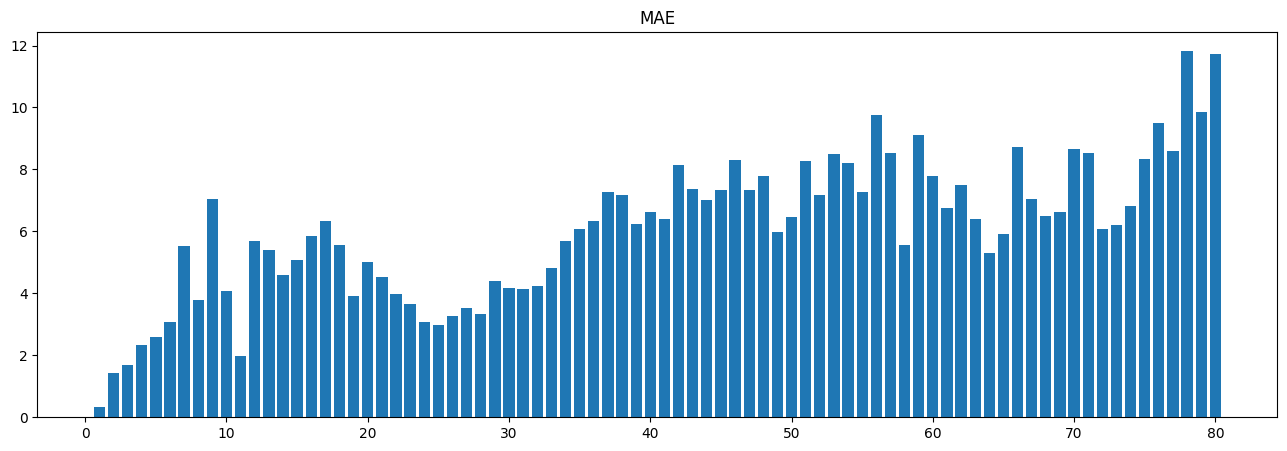

In [52]:
plt.figure(figsize=(16, 5))
plt.bar(df_test.groupby('age')['maes'].describe().index,
        df_test.groupby('age')['maes'].describe()['mean'])
plt.title("MAE");

## analyze the model's sensitivity

27.62


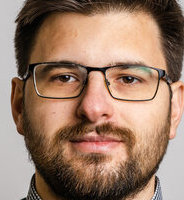

In [53]:
img= Image.open(os.path.join(drive_path, 'test_image_1.jpeg')).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age= age_model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

25.64


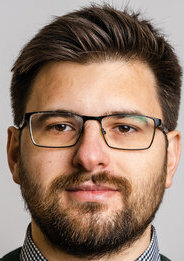

In [54]:
img= Image.open(os.path.join(drive_path, 'test_image_2.jpeg')).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age= age_model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

22.02


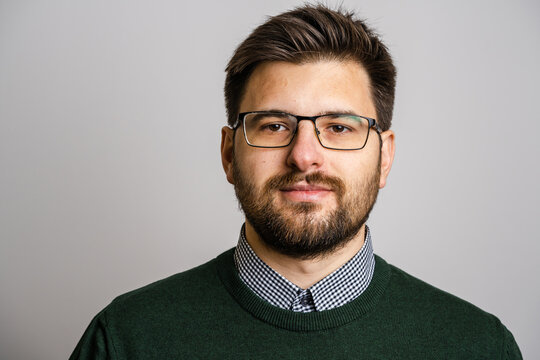

In [55]:
img= Image.open(os.path.join(drive_path, 'test_image.jpeg')).convert('RGB')
img_tensor= test_transform(img).unsqueeze(0)

with torch.inference_mode():
  predicted_age= age_model(img_tensor.to(device)).item()

print(f'{predicted_age:.2f}')
img

36.65


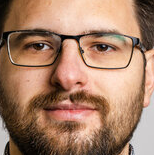

In [56]:
preds, img= inference(os.path.join(drive_path, 'test_image.jpeg'),
                      test_transform, age_model, face_detection= True)

print(f'{preds:.2f}')
img

42.31


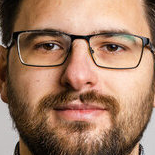

In [57]:
preds, img= inference(os.path.join(drive_path, 'test_image_2.jpeg'),
                      test_transform, age_model, face_detection= True)

print(f'{preds:.2f}')
img

## heatmap